In [2]:
!pip install numerapi halo

  Preparing metadata (setup.py) ... done
  Created wheel for halo: filename=halo-0.0.31-py3-none-any.whl size=11261 sha256=018a40ffb0875cbccd20544c9e2f3f72348ffdaca177187334726bbc44cdf4ab
  Stored in directory: /root/.cache/pip/wheels/41/c9/fc/65b2a2aec7a71b08ba8cce6f77e6311290cf646f42d41d7c28
Successfully built halo


In [3]:
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
import gc
import json
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm

from numerapi import NumerAPI

import sys
sys.path.insert(1, "/kaggle/input/utilspy/")
sys.path.insert(1, "/kaggle/input/example-model-sunshine-v2/")

path = "/kaggle/input/example-model-sunshine-v2/"
models_path = "/kaggle/input/example-model-sunshine-v2/models/"

from utils import (
    save_model,
#     load_model,
    neutralize,
    validation_metrics,
    ERA_COL,
    DATA_TYPE_COL,
    TARGET_COL,
    EXAMPLE_PREDS_COL,
)

# # download all the things
# PUBLIC_ID = "AFL3X7DE3VPROC25KPSENXRB5C5D23RU"
# SECRET_KEY = "I5ACBG5FY4BIEB6SY3JNT2YH4YFQPWSWOJ5MVX3XKEQZZ2Y6UCBXLVC4VIQK56XW"

# # Initialize API with API Keys
# napi = NumerAPI(public_id=PUBLIC_ID, 
#                          secret_key=SECRET_KEY, 
#                          verbosity="info")

# current_round = napi.get_current_round()
# print(f"The current round is {current_round}")

# # # Tournament data changes every week so we specify the round in their name. Training
# # # and validation data only change periodically, so no need to download them every time.
# # print("Downloading dataset files...")
dataset_name = "v4.1"
feature_set_name = "all"

# Path(f"./{dataset_name}").mkdir(parents=False, exist_ok=True)

# we'll use the int8 in this example in order to save RAM.
# if you remove the int8 suffix for each of these files, you'll get features between 0 and 1 as floats.
# int_8 files are much smaller...
# but are harder to work with because some packages don't like ints and the way NAs are encoded.

# # napi.download_dataset(f"{dataset_name}/train.parquet")
# # napi.download_dataset(f"{dataset_name}/validation.parquet")
# # napi.download_dataset(f"{dataset_name}/live.parquet", f"{dataset_name}/live_{current_round}.parquet")

# napi.download_dataset(f"{dataset_name}/train_int8.parquet")
# napi.download_dataset(f"{dataset_name}/validation_int8.parquet")
# napi.download_dataset(f"{dataset_name}/live_int8.parquet", f"{dataset_name}/live_int8_{current_round}.parquet")

# napi.download_dataset(f"{dataset_name}/validation_example_preds.parquet")
# napi.download_dataset(f"{dataset_name}/features.json")


print("Reading minimal training data")
# read the feature metadata and get a feature set (or all the features)

with open(f"{path+dataset_name}/features.json", "r") as f:
    feature_metadata = json.load(f)

features = list(feature_metadata["feature_stats"].keys()) # get all the features
# features = feature_metadata["feature_sets"]["small"] # get the small feature set
# features = feature_metadata["feature_sets"][feature_set_name]  # get the medium feature set
target_cols = feature_metadata["targets"]
# read in just those features along with era and target columns
read_columns = features + target_cols + [ERA_COL, DATA_TYPE_COL]

# note: sometimes when trying to read the downloaded data you get an error about invalid magic parquet bytes...
# if so, delete the file and rerun the napi.download_dataset to fix the corrupted file
training_data = pd.read_parquet(
    f"{path+dataset_name}/train_int8.parquet", columns=read_columns
)
# validation_data = pd.read_parquet(
#     f"{path+dataset_name}/validation_int8.parquet", columns=read_columns
# )
# live_data = pd.read_parquet(f"{dataset_name}/live_int8_{current_round}.parquet", columns=read_columns)

print("Training data:")
print(f"There are {len(features)} features")
print(f"There are {len(training_data[ERA_COL].unique())} eras numbered from {training_data[ERA_COL].unique()[0]} to {training_data[ERA_COL].unique()[-1]}")
print(f"There are {len(target_cols)-1} targets named {target_cols[1:]}")
print("----------------------------------------------------------------------")
# print("Validation data:")
# print(f"There are {len(validation_data[ERA_COL].unique())} eras numbered from {validation_data[ERA_COL].unique()[0]} to {validation_data[ERA_COL].unique()[-1]}")
# print("----------------------------------------------------------------------")
# print("Live data:")
# print(f"There are {len(live_data[ERA_COL].unique())} eras numbered from {live_data[ERA_COL].unique()[0]} to {live_data[ERA_COL].unique()[-1]}")

Reading minimal training data
Training data:
There are 1586 features
There are 574 eras numbered from 0001 to 0574
There are 28 targets named ['target_nomi_v4_20', 'target_nomi_v4_60', 'target_tyler_v4_20', 'target_tyler_v4_60', 'target_victor_v4_20', 'target_victor_v4_60', 'target_ralph_v4_20', 'target_ralph_v4_60', 'target_waldo_v4_20', 'target_waldo_v4_60', 'target_jerome_v4_20', 'target_jerome_v4_60', 'target_janet_v4_20', 'target_janet_v4_60', 'target_ben_v4_20', 'target_ben_v4_60', 'target_alan_v4_20', 'target_alan_v4_60', 'target_paul_v4_20', 'target_paul_v4_60', 'target_george_v4_20', 'target_george_v4_60', 'target_william_v4_20', 'target_william_v4_60', 'target_arthur_v4_20', 'target_arthur_v4_60', 'target_thomas_v4_20', 'target_thomas_v4_60']
----------------------------------------------------------------------


In [4]:
# # The features are no longer explicit feature groups, but you can see some pretty obvious patterns if you
# # visualize the feature correlation matrix. Feel free to construct your own groupings!
# plt.figure(figsize = (6,6))
# plt.imshow(training_data[training_data.era=='0001'][features].corr())

In [5]:
# # The earlier eras are smaller, but generally each era is 4000-5000 rows
# training_data.groupby(ERA_COL).size().plot()

# Feature Importance

In [6]:
# ADDITION by me
training_indexes = []
validation_indexes = []
for i in range(4):
    every_4th_era = training_data[ERA_COL].unique()[i::4]
    training_indexes.append(training_data[training_data[ERA_COL].isin(every_4th_era)].index)
#     every_4th_era = validation_data[ERA_COL].unique()[i::4]
#     validation_indexes.append(validation_data[validation_data[ERA_COL].isin(every_4th_era)].index)
    print(f'Getting training and validation indices: {i+1}/4')
    
# get all the data to possibly use for training
# all_data = pd.concat([training_data, validation_data])

# delete training and validation data to save space
# del training_data
# del validation_data
gc.collect()  # clear up memory

# Int8 datatype has pd.NA which don't play nice with models.  We simply fill NA with median values here
print("Cleaning up NAs")
medians = training_data[features].median(skipna=True).astype("int8")
# all_data[features] = all_data[features].fillna(medians)
# all_data[features] = all_data[features].astype("int8")  # make sure change to float32 if using the non int8 data!
# live_data[features] = live_data[features].fillna(medians)  # since live data is only one era, we need to use the median for all eras
# live_data[features] = live_data[features].astype("int8")  # make sure change to float32 if using the non int8 data!
training_data[features] = training_data[features].fillna(medians)  # since live data is only one era, we need to use the median for all eras
training_data[features] = training_data[features].astype("int8") 

# Alternatively could convert nan columns to be floats and replace pd.NA with np.nan
print("Cleaned up NAs")

# pd.to_pickle(pd.Series(training_indexes), f"training_indices.pkl")
# pd.to_pickle(pd.Series(validation_indexes), f"validation_indices.pkl")
# pd.to_pickle(all_data, f"all_data.pkl")
# pd.to_pickle(live_data, f"live_data.pkl")

Getting training and validation indices: 1/4
Getting training and validation indices: 2/4
Getting training and validation indices: 3/4
Getting training and validation indices: 4/4
Cleaning up NAs
Cleaned up NAs


In [22]:
def load_model(path):
    path = Path(f"{path}.pkl")
    print(path)
    if path.is_file():
        model = pd.read_pickle(f"{path}")
    else:
        model = False
    return model

model_folders = ["numerai-train-nomi-v4-20", "numerai-train-jerome-v4-60", "numerai-train-ralph-v4-20", "numerai-train-tyler-v4-20", "numerai-train-victor-v4-20", "numerai-train-waldo-v4-20"]

In [24]:
# # Very small fast params
# params_name = "vsm_lgbm"
# params = {"n_estimators": 200,
#           "learning_rate": 0.1,
#           "max_depth": 4,
#           "num_leaves": 2 ** 4,
#           "colsample_bytree": 0.1}

# # small fast params
# params_name = "sm_lgbm"
# params = {"n_estimators": 2000,
#           "learning_rate": 0.01,
#           "max_depth": 5,
#           "num_leaves": 2 ** 5,
#           "colsample_bytree": 0.1}

# recommended params
params_name = "lg_lgbm"
params = {
    "n_estimators": 20000,
    "learning_rate": 0.001,
    "max_depth": 6,
    "num_leaves": 2**6,
    "colsample_bytree": 0.1,
}

# loop through all of our favorite targets and build models on each of them - one over training data, one over all available data
# for the train_data models, we'll then predict on validation data
# for the all_data models, we'll predict on live
targets = [
    "target_nomi_v4_20",
    "target_jerome_v4_60",
    "target_ralph_v4_20",
    "target_tyler_v4_20",
    "target_victor_v4_20",
    "target_waldo_v4_20",
]

fi_results = pd.DataFrame({'Features': features})
imp_cols = []

for target, model_folder in zip(tqdm(targets), model_folders):
    for i, training_index in enumerate(tqdm(training_indexes)):
        prediction_col = f"{params_name}_{dataset_name}_{feature_set_name}_erasplit{i}_{target}"
        train_data_model_name = f"train_data_{prediction_col}.pkl"
#         print(f"Checking for existing model '{train_data_model_name}'")
#         train_model = pd.read_pickle(models_path+train_data_model_name)
        train_model = load_model(f"/kaggle/input/{model_folder}/models/{train_data_model_name}")

        if not train_model:
            print(f"Model not found, creating new one")
            train_model = LGBMRegressor(**params)
            # train on all of train and save the model so we don't have to train next time
            target_train_index = (training_data.loc[training_index, target].dropna().index)  # make sure we only train on rows which have this target
            train_model.fit(training_data.loc[target_train_index, features], training_data.loc[target_train_index, target])
            print(f"Saving new model: {train_data_model_name}")
            save_model(train_model, train_data_model_name)
            
        print(f"Model found")

        feature_importances = (train_model.feature_importances_ / sum(train_model.feature_importances_)) * 100
        fi_results[f'Importances {target} {i}'] = feature_importances
        imp_cols.append(f'Importances {target} {i}')
        
        







# prediction_cols = []
# for target in tqdm(targets):
#     for i, (training_index,validation_index) in enumerate(zip(training_indexes, validation_indexes)):
#         prediction_col = f"{params_name}_{dataset_name}_{feature_set_name}_erasplit{i}_{target}"
#         train_data_model_name = f"train_data_{prediction_col}.pkl"
#         print(f"Checking for existing model '{train_data_model_name}'")
#         train_model = pd.read_pickle(models_path+train_data_model_name)
#         print(f"Found model: {train_model}")
#         if not train_model:
#             print(f"Model not found, creating new one")
#             train_model = LGBMRegressor(**params)
#             # train on all of train and save the model so we don't have to train next time
#             target_train_index = (all_data.loc[training_index, target].dropna().index)  # make sure we only train on rows which have this target
#             train_model.fit(
#                 all_data.loc[target_train_index, features],
#                 all_data.loc[target_train_index, target],
#             )  # in case some of the targets are missing data
#             print(f"Saving new model: {train_data_model_name}")
#             save_model(train_model, train_data_model_name)

#         # predict on validation data
#         print(f"Predicting on validation data")
#         all_data.loc[validation_index, prediction_col] = train_model.predict(
#             all_data.loc[validation_index, features]
#         )
#         gc.collect()

#         # do the same thing for all data (for predicting on live)
#         all_index = training_index.union(validation_index)
#         all_data_model_name = f"all_data_{prediction_col}.pkl"
#         print(f"Checking for existing model '{all_data_model_name}'")
#         all_data_model = pd.read_pickle(models_path+all_data_model_name)
#         print(f"Found model: {all_data_model}")
#         if not all_data_model:
#             print(f"Model not found, creating new one")
#             all_data_model = LGBMRegressor(**params)
#             all_data_target_index = (
#                 all_data.loc[all_index, target].dropna().index
#             )  # make sure we only train on rows which have this target
#             # train on all of train and save the model so we don't have to train next time
#             all_data_model.fit(
#                 all_data.loc[all_data_target_index, features],
#                 all_data.loc[all_data_target_index, target],
#             )
#             print(f"Saving new model: {all_data_model_name}")
#             save_model(all_data_model, all_data_model_name)

#         # predict on live data
#         print(f"Predicting on live data")
#         live_data[prediction_col] = all_data_model.predict(
#             live_data[features].fillna(np.nan)
#         )  # filling live data with nans makes us ignore those features if necessary
#         gc.collect()

#         prediction_cols.append(prediction_col)

  0%|          | 0/4 [00:00<?, ?it/s]

/kaggle/input/numerai-train-nomi-v4-20/models/train_data_lg_lgbm_v4.1_all_erasplit0_target_nomi_v4_20.pkl.pkl
Ddd
Model found



 25%|██▌       | 1/4 [00:00<00:02,  1.16it/s]

/kaggle/input/numerai-train-nomi-v4-20/models/train_data_lg_lgbm_v4.1_all_erasplit1_target_nomi_v4_20.pkl.pkl
Ddd
Model found



 50%|█████     | 2/4 [00:02<00:02,  1.35s/it]

/kaggle/input/numerai-train-nomi-v4-20/models/train_data_lg_lgbm_v4.1_all_erasplit2_target_nomi_v4_20.pkl.pkl
Ddd
Model found



 75%|███████▌  | 3/4 [00:04<00:01,  1.48s/it]

/kaggle/input/numerai-train-nomi-v4-20/models/train_data_lg_lgbm_v4.1_all_erasplit3_target_nomi_v4_20.pkl.pkl
Ddd
Model found



  0%|          | 0/4 [00:00<?, ?it/s]

/kaggle/input/numerai-train-jerome-v4-60/models/train_data_lg_lgbm_v4.1_all_erasplit0_target_jerome_v4_60.pkl.pkl
Ddd
Model found



 25%|██▌       | 1/4 [00:01<00:05,  1.69s/it]

/kaggle/input/numerai-train-jerome-v4-60/models/train_data_lg_lgbm_v4.1_all_erasplit1_target_jerome_v4_60.pkl.pkl
Ddd
Model found



 50%|█████     | 2/4 [00:03<00:03,  1.69s/it]

/kaggle/input/numerai-train-jerome-v4-60/models/train_data_lg_lgbm_v4.1_all_erasplit2_target_jerome_v4_60.pkl.pkl
Ddd
Model found



 75%|███████▌  | 3/4 [00:04<00:01,  1.65s/it]

/kaggle/input/numerai-train-jerome-v4-60/models/train_data_lg_lgbm_v4.1_all_erasplit3_target_jerome_v4_60.pkl.pkl
Ddd
Model found



  0%|          | 0/4 [00:00<?, ?it/s]

/kaggle/input/numerai-train-ralph-v4-20/models/train_data_lg_lgbm_v4.1_all_erasplit0_target_ralph_v4_20.pkl.pkl
Ddd
Model found



 25%|██▌       | 1/4 [00:01<00:05,  1.67s/it]

/kaggle/input/numerai-train-ralph-v4-20/models/train_data_lg_lgbm_v4.1_all_erasplit1_target_ralph_v4_20.pkl.pkl
Ddd
Model found



 50%|█████     | 2/4 [00:03<00:03,  1.68s/it]

/kaggle/input/numerai-train-ralph-v4-20/models/train_data_lg_lgbm_v4.1_all_erasplit2_target_ralph_v4_20.pkl.pkl
Ddd
Model found



 75%|███████▌  | 3/4 [00:05<00:01,  1.72s/it]

/kaggle/input/numerai-train-ralph-v4-20/models/train_data_lg_lgbm_v4.1_all_erasplit3_target_ralph_v4_20.pkl.pkl
Ddd
Model found



  0%|          | 0/4 [00:00<?, ?it/s]

/kaggle/input/numerai-train-tyler-v4-20/models/train_data_lg_lgbm_v4.1_all_erasplit0_target_tyler_v4_20.pkl.pkl
Ddd
Model found



 25%|██▌       | 1/4 [00:01<00:05,  1.67s/it]

/kaggle/input/numerai-train-tyler-v4-20/models/train_data_lg_lgbm_v4.1_all_erasplit1_target_tyler_v4_20.pkl.pkl
Ddd
Model found



 50%|█████     | 2/4 [00:03<00:03,  1.65s/it]

/kaggle/input/numerai-train-tyler-v4-20/models/train_data_lg_lgbm_v4.1_all_erasplit2_target_tyler_v4_20.pkl.pkl
Ddd
Model found



 75%|███████▌  | 3/4 [00:04<00:01,  1.64s/it]

/kaggle/input/numerai-train-tyler-v4-20/models/train_data_lg_lgbm_v4.1_all_erasplit3_target_tyler_v4_20.pkl.pkl
Ddd
Model found



  0%|          | 0/4 [00:00<?, ?it/s]

/kaggle/input/numerai-train-victor-v4-20/models/train_data_lg_lgbm_v4.1_all_erasplit0_target_victor_v4_20.pkl.pkl
Ddd
Model found



 25%|██▌       | 1/4 [00:01<00:04,  1.66s/it]

/kaggle/input/numerai-train-victor-v4-20/models/train_data_lg_lgbm_v4.1_all_erasplit1_target_victor_v4_20.pkl.pkl
Ddd
Model found



 50%|█████     | 2/4 [00:03<00:03,  1.71s/it]

/kaggle/input/numerai-train-victor-v4-20/models/train_data_lg_lgbm_v4.1_all_erasplit2_target_victor_v4_20.pkl.pkl
Ddd
Model found



 75%|███████▌  | 3/4 [00:05<00:01,  1.71s/it]

/kaggle/input/numerai-train-victor-v4-20/models/train_data_lg_lgbm_v4.1_all_erasplit3_target_victor_v4_20.pkl.pkl
Ddd
Model found



  0%|          | 0/4 [00:00<?, ?it/s]

/kaggle/input/numerai-train-waldo-v4-20/models/train_data_lg_lgbm_v4.1_all_erasplit0_target_waldo_v4_20.pkl.pkl
Ddd
Model found



 25%|██▌       | 1/4 [00:01<00:04,  1.65s/it]

/kaggle/input/numerai-train-waldo-v4-20/models/train_data_lg_lgbm_v4.1_all_erasplit1_target_waldo_v4_20.pkl.pkl
Ddd
Model found



 50%|█████     | 2/4 [00:03<00:03,  1.66s/it]

/kaggle/input/numerai-train-waldo-v4-20/models/train_data_lg_lgbm_v4.1_all_erasplit2_target_waldo_v4_20.pkl.pkl
Ddd
Model found



 75%|███████▌  | 3/4 [00:05<00:01,  1.68s/it]

/kaggle/input/numerai-train-waldo-v4-20/models/train_data_lg_lgbm_v4.1_all_erasplit3_target_waldo_v4_20.pkl.pkl
Ddd
Model found



100%|██████████| 6/6 [00:39<00:00,  6.61s/it]


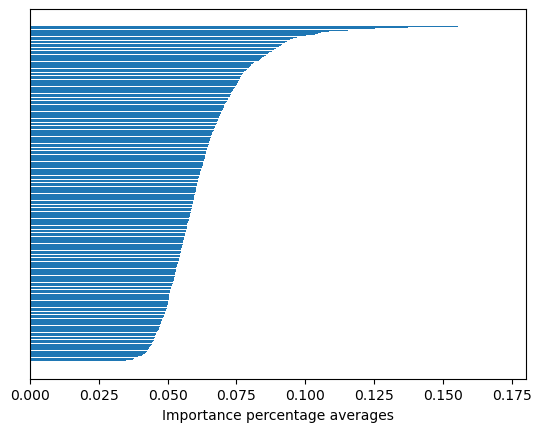

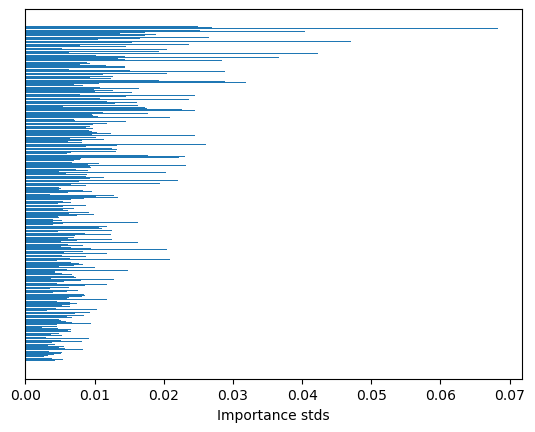

In [25]:
fi_results['avg importance'] = fi_results[imp_cols].mean(axis=1)
fi_results['std importance'] = fi_results[imp_cols].std(axis=1)

fi_results.sort_values(by=['avg importance', 'std importance'], inplace=True)

ax = plt.barh(fi_results['Features'], fi_results['avg importance'])
plt.xlabel('Importance percentage averages')
plt.yticks([]) 
plt.show()

ax = plt.barh(fi_results['Features'], fi_results['std importance'])
plt.xlabel('Importance stds')
plt.yticks([]) 
plt.show()

# pd.to_pickle(fi_results, f"fi_results.pkl")

In [29]:
fi_results['avg importance']

1516    0.033363
1476    0.033611
385     0.033811
1480    0.034407
964     0.034476
          ...   
622     0.145016
559     0.148085
1158    0.155586
1535    0.169741
1579    0.171544
Name: avg importance, Length: 1586, dtype: float64

In [90]:
features_high_avg = fi_results[fi_results['avg importance'] > 0.1]['Features'].values.tolist() # 46 features
features_med_avg = fi_results[fi_results['avg importance'] > 0.075]['Features'].values.tolist() # 277 features
features_low_avg = fi_results[fi_results['avg importance'] > 0.05]['Features'].values.tolist() # 1314 features
features_low_avg_high_std = fi_results[(fi_results['avg importance'] > 0.05) & (fi_results['std importance'] < 0.01)]['Features'].values.tolist() # 714 features
features_low_avg_med_std = fi_results[(fi_results['avg importance'] > 0.05) & (fi_results['std importance'] < 0.0075)]['Features'].values.tolist() # 410 features
features_low_avg_low_std = fi_results[(fi_results['avg importance'] > 0.05) & (fi_results['std importance'] < 0.005)]['Features'].values.tolist() # 112 features

my_features = [features_high_avg, features_med_avg, features_low_avg, features_low_avg_high_std, features_low_avg_med_std, features_low_avg_low_std]
my_features_names = ['features_high_avg', 'features_med_avg', 'features_low_avg', 'features_low_avg_high_std', 'features_low_avg_med_std', 'features_low_avg_low_std']

my_feature_dict = {k: v for k, v in zip(my_features_names, my_features)}

# Save dictionary to JSON file
with open('my_features.json', 'w') as f:
    json.dump(my_feature_dict, f)

In [79]:
features_sm = feature_metadata["feature_sets"]["small"] # get the small feature set
features_m = feature_metadata["feature_sets"]['medium']  # get the medium feature set
features_v2 = feature_metadata["feature_sets"]['v2_equivalent_features']  # get the v2 equivalent feature set
features_v3 = feature_metadata["feature_sets"]['v3_equivalent_features']  # get the v3 equivalent feature set
features_fncv3 = feature_metadata["feature_sets"]['fncv3_features']  # get the fncv3 feature set

numerai_features = [features_sm, features_m, features_v2, features_v3, features_fncv3]
numerai_features_names = ['features_sm', 'features_m', 'features_v2', 'features_v3', 'features_fncv3']

[[0.40625    0.03588144 0.02960526 0.02692308 0.03125   ]
 [0.75       0.23712949 0.21052632 0.16923077 0.23317308]
 [1.         0.88299532 0.875      0.82115385 0.88461538]
 [0.125      0.45553822 0.52302632 0.47788462 0.50721154]
 [0.         0.24336973 0.27960526 0.2875     0.28846154]
 [0.         0.0624025  0.0625     0.07980769 0.06730769]]


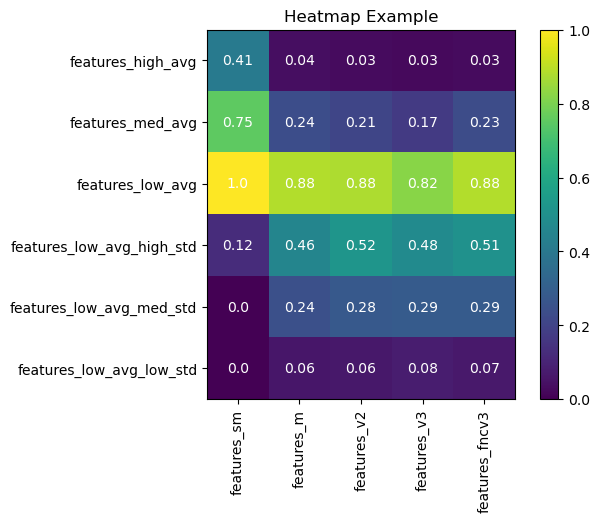

In [89]:
from sklearn.metrics import confusion_matrix

cm = np.empty((len(my_features), len(numerai_features)))
for i,list1 in enumerate(my_features):
    for j,list2 in enumerate(numerai_features):
        cm[i,j] = sum([1 for value in list1 if value in list2])/len(list2)

print(cm)

# Plot the heatmap
fig, ax = plt.subplots()
im = ax.imshow(cm)

# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set axis labels and title
ax.set_xticks(np.arange(cm.shape[1]))
ax.set_yticks(np.arange(cm.shape[0]))
ax.set_xticklabels(numerai_features_names, rotation=90)
ax.set_yticklabels(my_features_names)

ax.set_title('Heatmap Example')

# Loop over data dimensions and create annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text = ax.text(j, i, round(cm[i, j],2),
                       ha="center", va="center", color="w")

# Show plot
plt.show()